In [ ]:
! pip install wandb torchmetrics

In [2]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch.nn.functional import relu, sigmoid
import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset
import cv2
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms.functional as tvf
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import json

from torchmetrics import Dice
from torchmetrics.classification import BinaryJaccardIndex

from skimage.draw import polygon
from random import randint
import random
import math

import wandb

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

! kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels
! unzip "/content/chest-xray-masks-and-labels.zip"

In [4]:
IMAGE_PATH = "/content/Lung Segmentation/CXR_png"
MASK_PATH = "/content/Lung Segmentation/masks"
image_paths = os.listdir(IMAGE_PATH)
mask_paths = os.listdir(MASK_PATH)
# remove cxrs with no masks
image_paths = list(filter(lambda x : f"{x.split('.')[0]}_mask.png" in mask_paths, image_paths))


print(len(image_paths))
print(len(mask_paths))

566
704


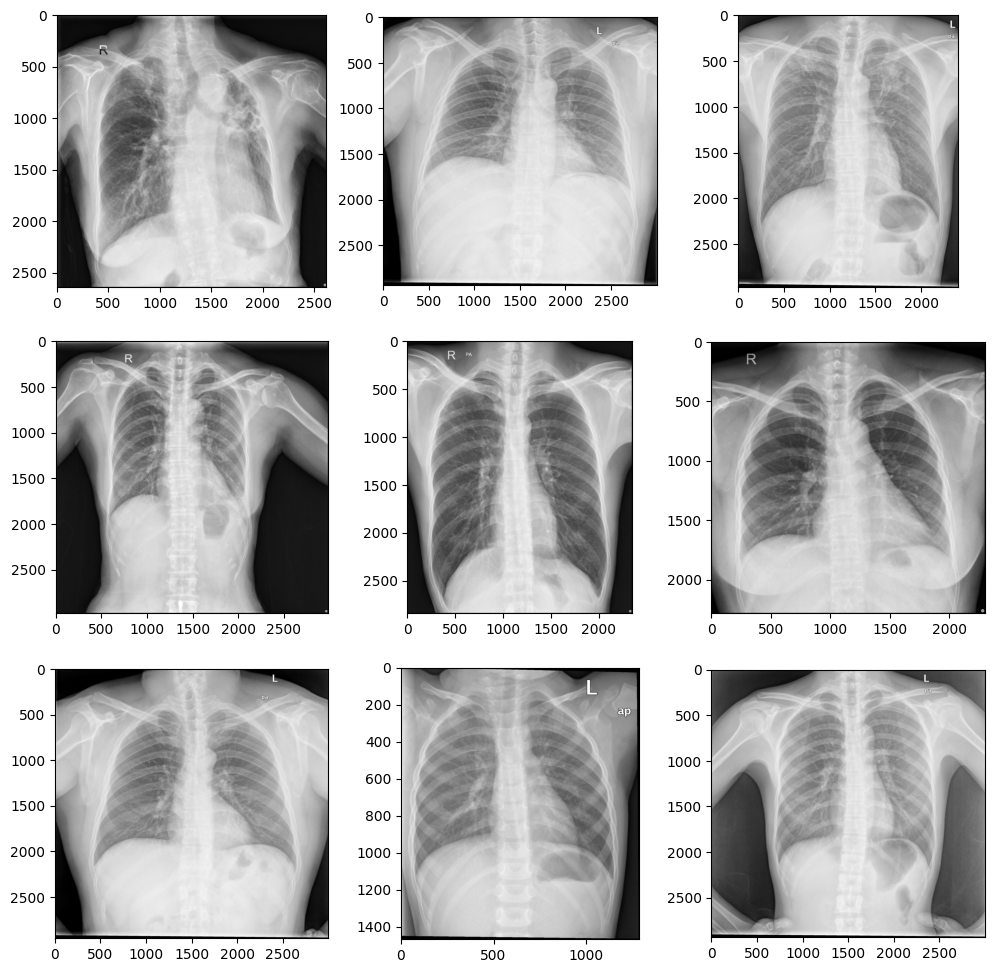

In [7]:
from random import randint
_, axs = plt.subplots(3,3, figsize=(12, 12))
axs = axs.flatten()
idx = randint(0, len(image_paths))
images_to_use = image_paths[idx:idx+9]
for img, ax in zip(images_to_use, axs):
    img_obj = plt.imread(f"{IMAGE_PATH}/{img}")
    ax.imshow(img_obj, cmap='gray')
plt.show()

In [ ]:
# image_paths_with_masks = copy.deepcopy(image_paths)
image_paths_with_masks = list(filter(lambda x : f"{x.split('.')[0]}_mask.png" in mask_paths, image_paths))
len(image_paths_with_masks)

566

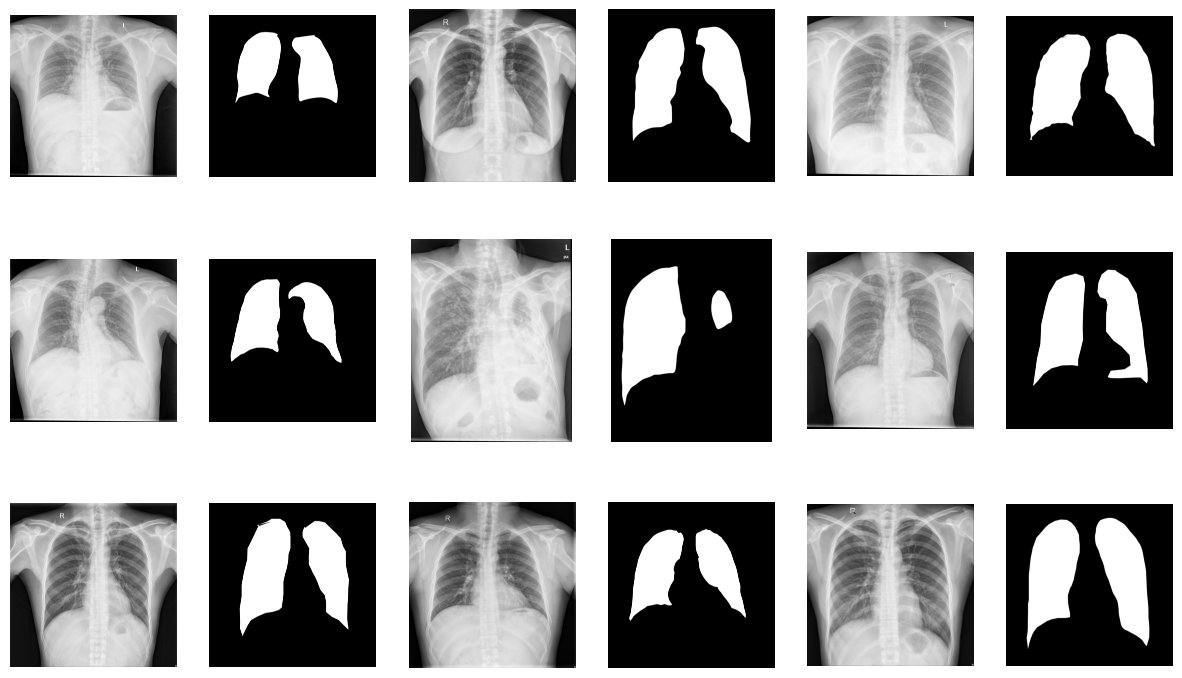

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
from random import randint
import copy

def ax_enumerate(data, start=0, step=1):
  for d in data:
    yield (start, d)
    start += step

images_to_use = []
masks_to_use = mask_paths[:9]
while len(images_to_use) < 9:
  idx = randint(0, len(image_paths)-1)
  image_path = image_paths[idx]
  # if f"{image_path.split('.')[0]}_mask.png" in mask_paths:
  images_to_use.append(image_path)

_, axs = plt.subplots(3,6, figsize=(15, 9))
axs = axs.flatten()
for i, img in ax_enumerate(images_to_use, step=2):
  image = cv2.imread(f"{IMAGE_PATH}/{img}", cv2.IMREAD_GRAYSCALE)
  mask = cv2.imread(f"{MASK_PATH}/{img.split('.')[0]}_mask.png", cv2.IMREAD_GRAYSCALE)
  # image = plt.imread(f"{IMAGE_PATH}/{img}")

  # mask = plt.imread(f"{MASK_PATH}/{img.split('.')[0]}_mask.png")
  img_ax = axs[i]
  mask_ax = axs[i+1]
  img_ax.imshow(image, cmap='gray')
  mask_ax.imshow(mask, cmap='gray')
  img_ax.axis("off")
  mask_ax.axis("off")
plt.show()

In [6]:
from torch.utils.data import Dataset
import cv2


class LungSegmentationDataset(Dataset):
    def __init__(self, base_img_path, base_mask_path, image_paths, masks_paths, image_size, img_transforms=None, aug_probability=0):
        self.base_img_path = base_img_path
        self.base_mask_path = base_mask_path
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = img_transforms
        self.image_size = image_size
        self.aug_probability = aug_probability

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get the image
        image_path = f"{self.base_img_path}/{self.image_paths[idx]}"
        mask_path = f"{self.base_mask_path}/{self.mask_paths[idx]}"
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image, mask = self.transform(image, mask)
        mask = (mask > 0.5).float()
        return image, mask

    def transform(self, image, mask):
      image = tvf.to_pil_image(image)
      mask = tvf.to_pil_image(mask)
      resize = transforms.Resize(size=(self.image_size, self.image_size))
      image = resize(image)
      mask = resize(mask)

      # Determine if we must apply augementations (can adjust how much of the dataset will be augmented)
      if random.random() <= self.aug_probability and self.transforms:
        # Determine augmentation to apply
        aug_index = random.randint(0, len(self.transforms)-1)
        augmentation_to_apply = list(self.transforms.keys())[aug_index]
        if augmentation_to_apply == 'ROTATE':
          rotation_angle = random.randint(-self.transforms['ROTATE'], self.transforms['ROTATE'])
          image = tvf.rotate(image, rotation_angle)
          mask = tvf.rotate(mask, rotation_angle)
        elif augmentation_to_apply == 'VFLIP':
          if random.random() > self.transforms['VFLIP']:
            image = tvf.vflip(image)
            mask = tvf.vflip(mask)
        elif augmentation_to_apply == 'HFLIP':
          if random.random() > self.transforms['HFLIP']:
            image = tvf.hflip(image)
            mask = tvf.hflip(mask)
        elif augmentation_to_apply == 'CROP':
          top_bounds = self.transforms['CROP']['top_bounds']
          left_bounds = self.transforms['CROP']['left_bounds']
          height_bounds = self.transforms['CROP']['height_bounds']
          width_bounds = self.transforms['CROP']['width_bounds']

          top = random.randint(top_bounds[0], top_bounds[1])
          left = random.randint(left_bounds[0], left_bounds[1])
          height = random.randint(height_bounds[0], height_bounds[1])
          width = random.randint(width_bounds[0], width_bounds[1])
          image = tvf.resized_crop(image, top, left, height, width, (self.image_size, self.image_size))
          mask = tvf.resized_crop(mask, top, left, height, width, (self.image_size, self.image_size))

      image = tvf.to_tensor(image)
      mask = tvf.to_tensor(mask)

      return image, mask


In [7]:
class UnetEncoderBlock(nn.Module):
    def __init__(self, features_in, features_out, kernel_size=3, stride=1, padding=1, max_pool=True):
        super().__init__()

        self.enc_1 = nn.Conv2d(features_in, features_out, kernel_size=kernel_size, stride=stride, padding=padding)
        self.enc_2 = nn.Conv2d(features_out, features_out, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batch_norm_1 = nn.BatchNorm2d(features_out)
        self.batch_norm_2 = nn.BatchNorm2d(features_out)
        self.max_pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        self.max_pool = max_pool

    def forward(self, x):
        enc_1 = self.enc_1(x)
        enc_1 = relu(self.batch_norm_1(enc_1))
        enc_2 = self.enc_2(enc_1)
        enc_2 = relu(self.batch_norm_2(enc_2))

        output_max = None
        if self.max_pool:
            output_max = self.max_pool_layer(enc_2)

        return enc_2, output_max

class UnetDecoderBlock(nn.Module):
    def __init__(self, features_in, features_out, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.conv_transpose = nn.ConvTranspose2d(features_in, features_out, kernel_size=2, stride=2)
        self.dec_1 = nn.Conv2d(features_in, features_out, kernel_size=kernel_size, stride=stride, padding=padding)
        self.dec_2 = nn.Conv2d(features_out, features_out, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batch_norm_1 = nn.BatchNorm2d(features_out)
        self.batch_norm_2 = nn.BatchNorm2d(features_out)

    def forward(self, x, encoder_input):
        dec_upconv_1 = self.conv_transpose(x)
        dec_1 = self.dec_1(torch.cat([dec_upconv_1, encoder_input], dim=1))
        dec_1 = relu(self.batch_norm_1(dec_1))
        dec_2 = self.dec_2(dec_1)
        dec_2 = relu(self.batch_norm_2(dec_2))
        return dec_2

class UnetEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder/Contracting
        self.encoder_blocks = nn.ModuleList([
          UnetEncoderBlock(1, 64),
          UnetEncoderBlock(64, 128),
          UnetEncoderBlock(128, 256),
          UnetEncoderBlock(256, 512),
          UnetEncoderBlock(512, 1024, max_pool=False)
        ])

    def forward(self, x):
        encoder_outputs = []
        for encoder_block in self.encoder_blocks:
            before_max_pool, x = encoder_block(x if torch.is_tensor(x) else before_max_pool)
            if torch.is_tensor(x):
                x = x.to(config.DEVICE)
            before_max_pool = before_max_pool.to(config.DEVICE)
            encoder_outputs.insert(0, before_max_pool)

        return x if torch.is_tensor(x) else before_max_pool, encoder_outputs[1:]

class UnetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder_blocks = nn.ModuleList([
          UnetDecoderBlock(1024, 512),
          UnetDecoderBlock(512, 256),
          UnetDecoderBlock(256, 128),
          UnetDecoderBlock(128, 64)
        ])

    def forward(self, x, encoder_inputs):
        for i, decoder_block in enumerate(self.decoder_blocks):
            x = decoder_block(x, encoder_inputs[i])

        return x


class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # Encoder/Contracting
        self.encoder = UnetEncoder()
        # Decoder/Expanding
        self.decoder = UnetDecoder()
        # Unet Output
        self.output_layer = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        encodes, encoder_outputs = self.encoder(x)
        decodes = self.decoder(encodes, encoder_outputs)

        output = sigmoid(self.output_layer(decodes))

        return output



In [17]:
import os
import torch


class Config(object):
  DATASET_PATH = os.path.join("/content/Lung Segmentation")

  IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "CXR_png")
  MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")

  TRAIN_VALIDATION_SPLIT = 0.8
  TEST_SPLIT = 0.5

  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  PIN_MEMORY = True if DEVICE == "cuda" else False

  NUM_CHANNELS = 1
  NUM_CLASSES = 1

  INIT_LR = 1e-4
  NUM_EPOCHS = 20
  BATCH_SIZE = 16

  INPUT_IMAGE_WIDTH = 256
  INPUT_IMAGE_HEIGHT = 256

  MOMENTUM = 0.999

  GRADIENT_CLIPPING = 1.0

  WEIGHT_DECAY = 1e-8

config = Config()

In [11]:
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))

train_images, test_images  = train_test_split(imagePaths, train_size=config.TRAIN_VALIDATION_SPLIT, random_state=42)
val_images, test_images = train_test_split(test_images, test_size=config.TEST_SPLIT, random_state=42)

train_images_names = list(map(lambda x : x.split('/')[-1], train_images))
train_masks = list(map(lambda x: f"{x.split('.')[0]}_mask.png", train_images_names))

val_images_names = list(map(lambda x : x.split('/')[-1], val_images))
val_masks = list(map(lambda x: f"{x.split('.')[0]}_mask.png", val_images_names))

test_images_names = list(map(lambda x : x.split('/')[-1], test_images))
test_masks = list(map(lambda x: f"{x.split('.')[0]}_mask.png", test_images_names))

train_transforms_to_use = {
    'ROTATE': 30,
    'VFLIP': 0.4,
    'HFLIP': 0.4,
    'CROP': {
        'top_bounds': [(config.INPUT_IMAGE_HEIGHT//3)*2, config.INPUT_IMAGE_HEIGHT],
        'left_bounds': [0, (config.INPUT_IMAGE_WIDTH//3)],
        'height_bounds': [(config.INPUT_IMAGE_HEIGHT//2), (config.INPUT_IMAGE_HEIGHT//4)*3],
        'width_bounds': [(config.INPUT_IMAGE_WIDTH//2), (config.INPUT_IMAGE_WIDTH//4)*3],
    }
}

trainDS = LungSegmentationDataset(base_img_path=config.IMAGE_DATASET_PATH,
                        base_mask_path=config.MASK_DATASET_PATH,
                        image_paths=train_images_names,
                        masks_paths=train_masks,
                        img_transforms=train_transforms_to_use,
                       aug_probability=0.5,
                       image_size=config.INPUT_IMAGE_HEIGHT)
valDS = LungSegmentationDataset(base_img_path=config.IMAGE_DATASET_PATH,
                      base_mask_path=config.MASK_DATASET_PATH,
                      image_paths=val_images_names,
                      masks_paths=val_masks,
                      image_size=config.INPUT_IMAGE_HEIGHT)
testDS = LungSegmentationDataset(base_img_path=config.IMAGE_DATASET_PATH,
                        base_mask_path=config.MASK_DATASET_PATH,
                        image_paths=test_images_names,
                        masks_paths=test_masks,
                        image_size=config.INPUT_IMAGE_HEIGHT)

trainLoader = DataLoader(trainDS, shuffle=True, batch_size=config.BATCH_SIZE)
valLoader = DataLoader(valDS, shuffle=True, batch_size=config.BATCH_SIZE)
testLoader = DataLoader(testDS, shuffle=True, batch_size=config.BATCH_SIZE)
print(f"{len(trainDS)} images in the training set")
print(f"{len(valDS)} images in the validation set")
print(f"{len(testDS)} images in the test set")

640 images in the training set
80 images in the validation set
80 images in the test set


In [12]:
dice_coef = Dice(average='micro').to(config.DEVICE)
i_o_u = BinaryJaccardIndex().to(config.DEVICE)

In [13]:
class IoULoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - i_o_u(y_pr, y_gt.to(torch.long).to(config.DEVICE))


class BCEIoULoss(IoULoss):
    __name__ = 'bce_i_o_u_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_i_o_u=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_i_o_u=lambda_i_o_u
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        i_o_u_score = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_i_o_u*i_o_u_score) + (self.lambda_bce* bce)

In [15]:
unet = UNet().to(config.DEVICE)
lossFunc = BCEIoULoss(activation=None, lambda_i_o_u=0.5)
opt = Adam(unet.parameters(),
           lr=config.INIT_LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, "max", patience=10
)
trainSteps = math.ceil(len(trainDS) / config.BATCH_SIZE)
valSteps = math.ceil(len(valDS) / config.BATCH_SIZE)
print(trainSteps)
print(valSteps)

40
5


In [16]:
torch.cuda.empty_cache()

In [18]:
wandb.init(
    project="UNet-Lung-Segmentation",
    config={
        "learning_rate": 1e-5,
        "architecture": "UNet",
        "dataset": "chest-xray-masks-and-labels",
        "epochs": 20,
        "batchSize": 16
    },
    name="Lung Segmentation"
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [27]:
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
  unet.train()
  totalTrainLoss = 0
  totalValLoss = 0
  total_training_dice = 0
  total_validation_dice = 0
  total_training_iou = 0
  total_validation_iou = 0

  for input_img, mask_labels in trainLoader:
   input_img, mask_labels = (input_img.to(config.DEVICE), mask_labels.to(config.DEVICE))
   pred = unet(input_img)
   loss = lossFunc(pred, mask_labels)
   totalTrainLoss += loss

   opt.zero_grad()
   loss.backward()
  #  torch.nn.utils.clip_grad_norm_(unet.parameters(), config.GRADIENT_CLIPPING)
   opt.step()

   training_dice = dice_coef(pred, mask_labels.to(torch.long).to(config.DEVICE))
   total_training_dice += training_dice
   training_iou = i_o_u(pred, mask_labels.to(torch.long).to(config.DEVICE))
   total_training_iou += training_iou

  with torch.no_grad():
    unet.eval()
    for input_img, mask_labels in valLoader:
        input_img, mask_labels = (input_img.to(config.DEVICE), mask_labels.to(config.DEVICE))
        pred = unet(input_img)

        validation_loss = lossFunc(pred, mask_labels)
        totalValLoss += validation_loss
        validation_iou = i_o_u(pred, mask_labels.to(torch.long).to(config.DEVICE))
        total_validation_iou += validation_iou
        validation_dice = dice_coef(pred, mask_labels.to(torch.long).to(config.DEVICE))
        total_validation_dice += validation_dice

  scheduler.step(validation_loss)
  avgTrainLoss = totalTrainLoss / trainSteps
  avg_train_dice = total_training_dice / trainSteps
  avg_train_iou = total_training_iou / trainSteps
  avgValLoss = totalValLoss / valSteps
  avg_val_dice = total_validation_dice / valSteps
  avg_val_iou = total_validation_iou / valSteps

  print(f"Epoch {e+1}/{config.NUM_EPOCHS}")
  print(f"Train loss: {avgTrainLoss}, Validation Loss: {avgValLoss}")
  print(f"Train Dice: {avg_train_dice}, Validation Dice: {avg_val_dice}")
  print(f"Train IoU: {avg_train_iou}, Validation IoU: {avg_val_iou}")

  wandb.log({
      "train_loss": avgTrainLoss,
      "validation_loss": avgValLoss,
      "train_dice": avg_train_dice,
      "validation_dice": avg_val_dice,
      "train_iou": avg_train_iou,
      "validation_iou": avg_val_iou
      })

endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

  5%|▌         | 1/20 [02:58<56:40, 178.96s/it]

Epoch 1/20
Train loss: 0.41251859068870544, Validation Loss: 0.4335825443267822
Train Dice: 0.7807110548019409, Validation Dice: 0.7868534326553345
Train IoU: 0.6409077644348145, Validation IoU: 0.6487805843353271


 10%|█         | 2/20 [05:58<53:47, 179.28s/it]

Epoch 2/20
Train loss: 0.41354280710220337, Validation Loss: 0.4348130226135254
Train Dice: 0.7830595374107361, Validation Dice: 0.7861512899398804
Train IoU: 0.6437979936599731, Validation IoU: 0.6477169394493103


 15%|█▌        | 3/20 [08:53<50:16, 177.45s/it]

Epoch 3/20
Train loss: 0.4136870801448822, Validation Loss: 0.43814346194267273
Train Dice: 0.7826783657073975, Validation Dice: 0.7848966717720032
Train IoU: 0.643368661403656, Validation IoU: 0.646160900592804


 20%|██        | 4/20 [11:48<47:02, 176.42s/it]

Epoch 4/20
Train loss: 0.4139399528503418, Validation Loss: 0.43439602851867676
Train Dice: 0.7844958901405334, Validation Dice: 0.7869001030921936
Train IoU: 0.6458883285522461, Validation IoU: 0.648927628993988


 25%|██▌       | 5/20 [14:43<43:59, 175.93s/it]

Epoch 5/20
Train loss: 0.41160041093826294, Validation Loss: 0.4340226352214813
Train Dice: 0.7833895683288574, Validation Dice: 0.7867603898048401
Train IoU: 0.6444242596626282, Validation IoU: 0.6487070918083191


 30%|███       | 6/20 [17:41<41:14, 176.75s/it]

Epoch 6/20
Train loss: 0.4122764766216278, Validation Loss: 0.4337987005710602
Train Dice: 0.785301148891449, Validation Dice: 0.7868602275848389
Train IoU: 0.6467761397361755, Validation IoU: 0.6489302515983582


 35%|███▌      | 7/20 [20:36<38:07, 176.00s/it]

Epoch 7/20
Train loss: 0.4099118709564209, Validation Loss: 0.43592801690101624
Train Dice: 0.7834472060203552, Validation Dice: 0.7864773273468018
Train IoU: 0.6444968581199646, Validation IoU: 0.6488780975341797


 40%|████      | 8/20 [23:30<35:04, 175.35s/it]

Epoch 8/20
Train loss: 0.40848827362060547, Validation Loss: 0.4349128305912018
Train Dice: 0.7855050563812256, Validation Dice: 0.7862016558647156
Train IoU: 0.6470390558242798, Validation IoU: 0.6479398608207703


 45%|████▌     | 9/20 [26:24<32:04, 174.96s/it]

Epoch 9/20
Train loss: 0.4056013524532318, Validation Loss: 0.4357704818248749
Train Dice: 0.7857899069786072, Validation Dice: 0.7839691638946533
Train IoU: 0.6474577784538269, Validation IoU: 0.645108163356781


 50%|█████     | 10/20 [29:22<29:19, 176.00s/it]

Epoch 10/20
Train loss: 0.41245561838150024, Validation Loss: 0.4343368709087372
Train Dice: 0.7859910130500793, Validation Dice: 0.7847643494606018
Train IoU: 0.6480292677879333, Validation IoU: 0.6460978388786316


 55%|█████▌    | 11/20 [32:20<26:29, 176.61s/it]

Epoch 11/20
Train loss: 0.40589866042137146, Validation Loss: 0.4348251521587372
Train Dice: 0.7867714166641235, Validation Dice: 0.7853729128837585
Train IoU: 0.648949146270752, Validation IoU: 0.6471344828605652


 60%|██████    | 12/20 [35:18<23:36, 177.06s/it]

Epoch 12/20
Train loss: 0.4073556959629059, Validation Loss: 0.4346589148044586
Train Dice: 0.7866779565811157, Validation Dice: 0.7853512167930603
Train IoU: 0.6488041281700134, Validation IoU: 0.6469228863716125


 65%|██████▌   | 13/20 [38:17<20:42, 177.52s/it]

Epoch 13/20
Train loss: 0.4088643491268158, Validation Loss: 0.43481117486953735
Train Dice: 0.7847311496734619, Validation Dice: 0.78672856092453
Train IoU: 0.6461881399154663, Validation IoU: 0.6487798690795898


 70%|███████   | 14/20 [41:12<17:40, 176.67s/it]

Epoch 14/20
Train loss: 0.4048730432987213, Validation Loss: 0.4352193772792816
Train Dice: 0.7869201898574829, Validation Dice: 0.7859284281730652
Train IoU: 0.6490349769592285, Validation IoU: 0.647631824016571


 75%|███████▌  | 15/20 [44:08<14:43, 176.66s/it]

Epoch 15/20
Train loss: 0.4082450866699219, Validation Loss: 0.4347570538520813
Train Dice: 0.7856304049491882, Validation Dice: 0.7855975031852722
Train IoU: 0.6473259329795837, Validation IoU: 0.647059977054596


 80%|████████  | 16/20 [47:05<11:46, 176.69s/it]

Epoch 16/20
Train loss: 0.403451532125473, Validation Loss: 0.4353742301464081
Train Dice: 0.7873004078865051, Validation Dice: 0.7864861488342285
Train IoU: 0.6498066782951355, Validation IoU: 0.6482523083686829


 85%|████████▌ | 17/20 [50:02<08:50, 176.82s/it]

Epoch 17/20
Train loss: 0.4069767892360687, Validation Loss: 0.43530145287513733
Train Dice: 0.7862500548362732, Validation Dice: 0.7862785458564758
Train IoU: 0.648109495639801, Validation IoU: 0.6479359269142151


 90%|█████████ | 18/20 [52:59<05:53, 176.91s/it]

Epoch 18/20
Train loss: 0.4043232500553131, Validation Loss: 0.43621817231178284
Train Dice: 0.7857398390769958, Validation Dice: 0.7866609692573547
Train IoU: 0.6475335359573364, Validation IoU: 0.6488849520683289


 95%|█████████▌| 19/20 [55:54<02:56, 176.24s/it]

Epoch 19/20
Train loss: 0.4039313793182373, Validation Loss: 0.4350678026676178
Train Dice: 0.7882651686668396, Validation Dice: 0.7867600321769714
Train IoU: 0.6510092616081238, Validation IoU: 0.6487309336662292


100%|██████████| 20/20 [58:49<00:00, 176.47s/it]

Epoch 20/20
Train loss: 0.4099434018135071, Validation Loss: 0.4352845847606659
Train Dice: 0.7839053273200989, Validation Dice: 0.7853055000305176
Train IoU: 0.645233690738678, Validation IoU: 0.6466684937477112
Total time taken to train the model: 3529.47s


In [28]:
   totalTestLoss = 0
   total_test_iou = 0
   total_test_dice = 0
   testSteps = math.ceil(len(testDS) / config.BATCH_SIZE)
   masks_to_print = []
   with torch.no_grad():
    unet.eval()
    for input_img, mask_labels in testLoader:
      input_img, mask_labels = (input_img.to(config.DEVICE), mask_labels.to(config.DEVICE))
      pred = unet(input_img)
      totalTestLoss += lossFunc(pred, mask_labels)
      test_iou = i_o_u(pred, mask_labels)
      total_test_iou += test_iou
      test_dice = dice_coef(pred, mask_labels.to(torch.long).to(config.DEVICE))
      total_test_dice += test_dice
      masks_to_print.append((input_img, pred, mask_labels))
    avg_test_loss = totalTestLoss / testSteps
    avg_test_dice = total_test_dice / testSteps
    avg_test_iou = total_test_iou / testSteps
    print(f"Test loss: {avg_test_loss}")
    print(f"Test Dice: {avg_test_dice}")
    print(f"Test IoU: {avg_test_iou}")

    wandb.log({
    "test_loss": avg_test_loss,
    "test_dice": avg_test_dice,
    "test_iou": avg_test_iou
    })

Test loss: 0.44894155859947205
Test Dice: 0.7769423723220825
Test IoU: 0.6355838179588318


In [29]:
wandb.finish()

test_dice,▁
test_iou,▁
test_loss,▁
train_dice,▁▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
train_iou,▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
train_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_dice,▁▇▇▇████▇███████████████████████████████
validation_iou,▁▇▆▇████▇███████████████████████████████
validation_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_dice,0.77694
test_iou,0.63558


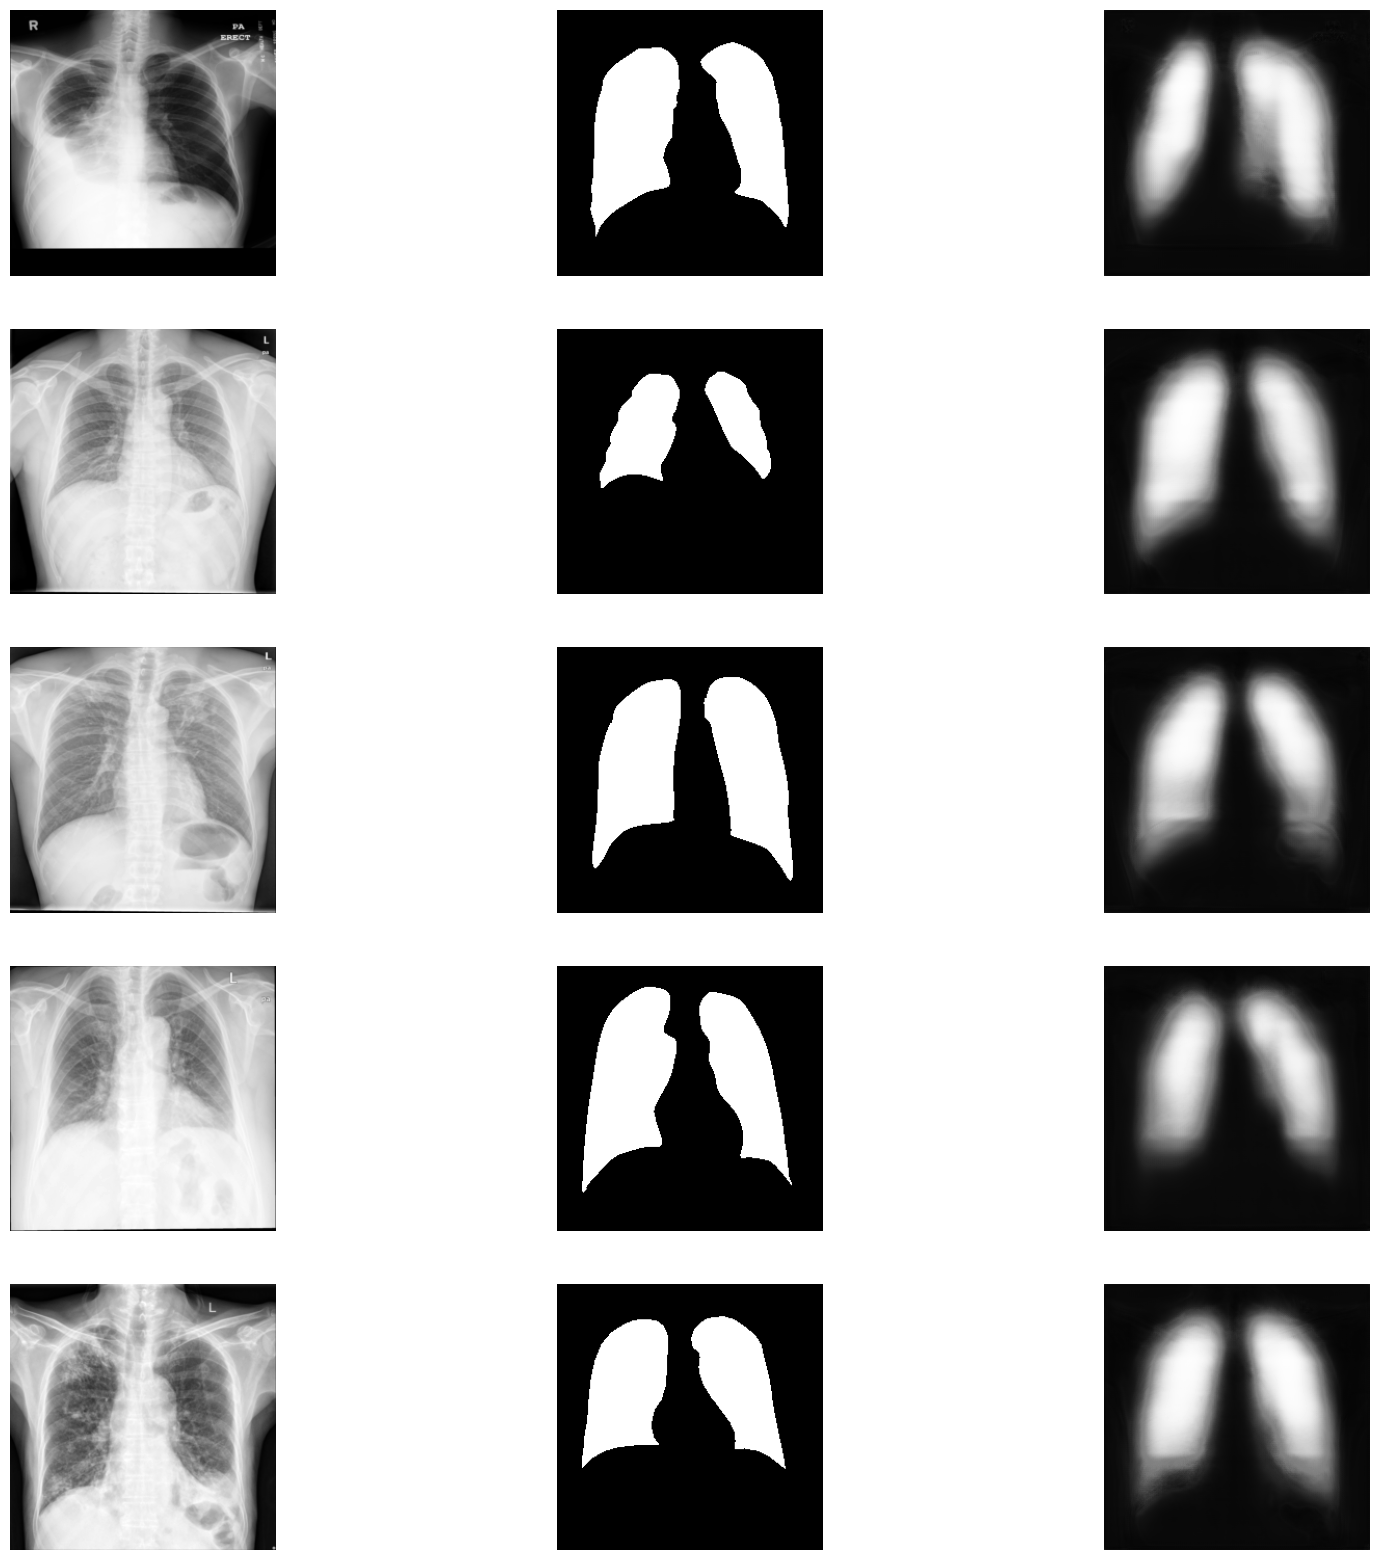

In [30]:
def ax_enumerate(data, start=0, step=1):
  for d in data:
    yield (start, d)
    start += step

_, axs = plt.subplots(5,3, figsize=(20, 20))
axs = axs.flatten()
for i, img in ax_enumerate(masks_to_print, step=3):
  mask_true = img[2]
  mask_pred = img[1]
  input_img = img[0]

  # mask_pred = (mask_pred > 0.4).float()

  true_ax = axs[i+1]
  pred_ax = axs[i+2]
  img_ax = axs[i]
  img_ax.imshow(input_img[0].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
  true_ax.imshow(mask_true[0].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
  pred_ax.imshow(mask_pred[0].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
  true_ax.axis("off")
  pred_ax.axis("off")
  img_ax.axis('off')
plt.show()